In [1]:
# Exploration of possible features to pull from name.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [23]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.tree import DecisionTreeRegressor

In [3]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [4]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [5]:
urlRegEx = '[^._]+[.]\w*wiki\w*[.][^_]+'

# Extract info from page

pageInfo = []

for pageStr in all_df.Page.values:
    midSplit = re.split('[_](' + urlRegEx + ')[_]', pageStr)
    thisPageInfo = midSplit[:2]
    midSplit = re.split('[_]', midSplit[2])
    thisPageInfo.extend(midSplit)
    
    pageInfo.append(thisPageInfo)
    
# Do a transpose, now in shape nInfo, nSamples

pageInfo = [[pageInfo[j][i] for j in range(len(pageInfo))] for i in range(len(pageInfo[0]))]

toInfoIndex = {'name' : 0, 'project' : 1, 'access' : 2, 'agent' : 3}
colNames = ['name', 'project', 'access', 'agent']

# Convert info to numerical

for i in range(1, 4):
    name = colNames[i]
    infoCol = np.array(pageInfo[i])
    infoCol_vals = np.unique(infoCol)
    infoCol_map = dict(zip(infoCol_vals, np.arange(len(infoCol_vals))))
    infoCol = [infoCol_map[x] for x in infoCol]
    all_df.insert(i, name, infoCol)

all_df.insert(1, 'name', pageInfo[0])
all_df[:3]

,Page,name,project,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


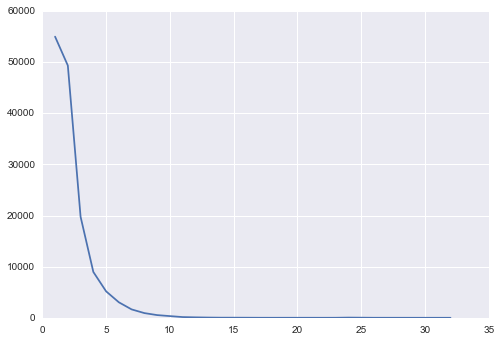

,Page,name,project,access,agent,numWords,2015-07-01,2015-07-02,2015-07-03,2015-07-04,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,1,18.0,11.0,5.0,13.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,1,11.0,14.0,15.0,18.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,1,1.0,0.0,1.0,1.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


In [6]:
numWords = []

for name in all_df['name']:
    num = len(re.split(r'_', name))
    numWords.append(num)
        
numWords = np.array(numWords)
vals, counts = np.unique(numWords, return_counts = True)
plt.plot(vals, counts)
plt.show()
numWords[numWords > 6] = 6

all_df.insert(5, 'numWords', numWords)

all_df[:3]

In [7]:
numNums = []

for name in all_df['name']:
    num = len(re.split(r'\d', name))
    numNums.append(num)
        
numNums = np.array(numNums)
numNums[numNums > 1] = 2
vals, counts = np.unique(numNums, return_counts = True)
print(np.vstack((vals,counts)).T)
print(counts[1:].sum())

#all_df.insert(6, 'numNums', numWords)

all_df[:3]

[[     1 130268]
 [     2  14795]]
14795


,Page,name,project,access,agent,numWords,2015-07-01,2015-07-02,2015-07-03,2015-07-04,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,1,18.0,11.0,5.0,13.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,1,11.0,14.0,15.0,18.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,1,1.0,0.0,1.0,1.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


14751
14068


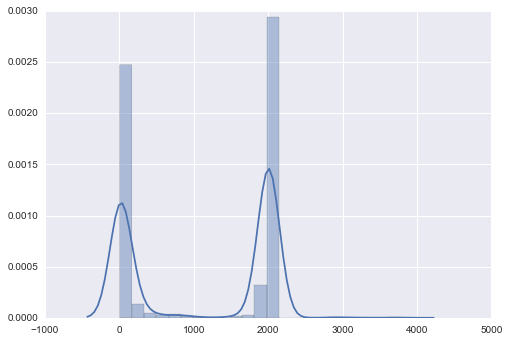

48.0
[ 0.  1.  2.]


,Page,name,project,access,agent,numWords,nameNums,2015-07-01,2015-07-02,2015-07-03,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,1,1.0,18.0,11.0,5.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,1,1.0,11.0,14.0,15.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,1,1.0,1.0,0.0,1.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,4minute,9,0,3,1,1.0,35.0,13.0,10.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You,9,0,3,5,1.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
5,5566_zh.wikipedia.org_all-access_spider,5566,9,0,3,1,2.0,12.0,7.0,4.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
6,91Days_zh.wikipedia.org_all-access_spider,91Days,9,0,3,1,1.0,0.0,0.0,0.0,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
7,A'N'D_zh.wikipedia.org_all-access_spider,A'N'D,9,0,3,1,0.0,118.0,26.0,30.0,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
8,AKB48_zh.wikipedia.org_all-access_spider,AKB48,9,0,3,1,1.0,5.0,23.0,14.0,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
9,ASCII_zh.wikipedia.org_all-access_spider,ASCII,9,0,3,1,0.0,6.0,3.0,5.0,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0


In [8]:
# Let's look at statistics of numbers inside names.

nameNums = []
matches = []
for name in all_df['name']:
    match = re.search(r'\d+', name)
    matches.append(match)
    if match != None:
        num = float(match.group())
    else:
        num = 0
    nameNums.append(num)
        
nameNums = np.array(nameNums)
print(np.sum(nameNums > 0))
mask = (nameNums > 0) & (nameNums < 4e3)
print(np.sum(mask))
sns.distplot(nameNums[mask])
plt.show()

print(float(matches[8].group()))

# Now put into df
mask = (0 < nameNums) & (nameNums < 1000)
nameNums[mask] = 1
mask = nameNums >= 1000
nameNums[mask] = 2
print(np.unique(nameNums))

all_df.insert(6, 'nameNums', nameNums)

all_df[:10]

i =  0 	 ['NE'] 2
i =  4 	 [] 0
i =  6 	 [] 0
i =  8 	 ['AKB'] 3
7352


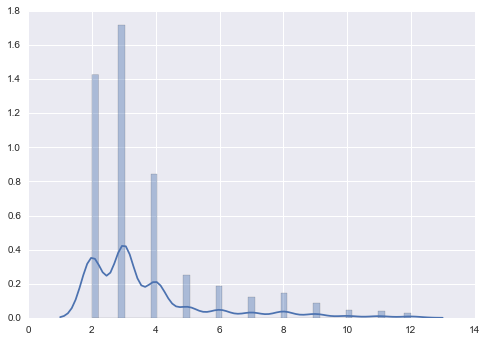

[1 2 3 4 5]


,Page,name,project,access,agent,numWords,capNums,nameNums,2015-07-01,2015-07-02,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,1,2,1.0,18.0,11.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,1,2,1.0,11.0,14.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,1,1,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,4minute,9,0,3,1,1,1.0,35.0,13.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You,9,0,3,5,1,1.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [14]:
# Let's look at number of capital letters - number of words.

capNums = []
matches = []
for name in all_df['name']:
    match = re.findall(r'[A-Z][A-Z]+', name)
    matches.append(match)
    num = 0
    for s in match:
        num += len(s)
    capNums.append(num)

for i in [0, 4, 6, 8]:
    print('i = ', i, '\t', matches[i], capNums[i])
    
capNums = np.array(capNums)
print(np.sum(capNums > 0))
mask = (capNums < 13) & (capNums > 0)
sns.distplot(capNums[mask])
plt.show()

# Put into dataframe.

mask = capNums > 4
capNums[mask] = 5
capNums[capNums == 0] = 1
print(np.unique(capNums))

all_df.insert(6, 'capNums', capNums)

all_df[:5]

i =  0 	 2
i =  4 	 4
i =  6 	 4
i =  8 	 3


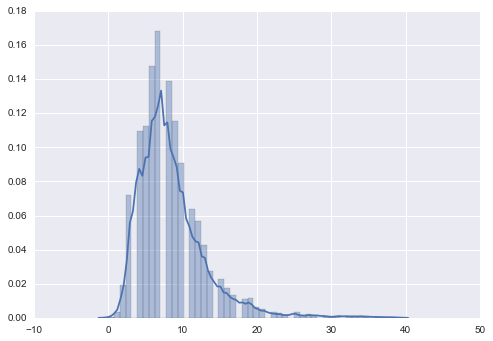

In [15]:
# Let's look at largest word length

wordLengths = []
for name in all_df['name']:
    words = re.split(r'_|\d', name)
    matches.append(match)
    if words:
        lengths = np.array([len(x) for x in words])
        wordLengths.append(np.amax(lengths))
    else:
        wordLengths.append(0)

for i in [0, 4, 6, 8]:
    print('i = ', i, '\t', wordLengths[i])
    
wordLengths = np.array(wordLengths)
sns.distplot(wordLengths[wordLengths < 40])
plt.show()

# put into data frame

all_df.insert(7, 'wordLength', wordLengths)

In [16]:
all_df[:10]

,Page,name,project,access,agent,numWords,capNums,wordLength,nameNums,2015-07-01,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,1,2,2,1.0,18.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,1,2,2,1.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,1,1,1,1.0,1.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,4minute,9,0,3,1,1,6,1.0,35.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You,9,0,3,5,1,4,1.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
5,5566_zh.wikipedia.org_all-access_spider,5566,9,0,3,1,1,0,2.0,12.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
6,91Days_zh.wikipedia.org_all-access_spider,91Days,9,0,3,1,1,4,1.0,0.0,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
7,A'N'D_zh.wikipedia.org_all-access_spider,A'N'D,9,0,3,1,1,5,0.0,118.0,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
8,AKB48_zh.wikipedia.org_all-access_spider,AKB48,9,0,3,1,3,3,1.0,5.0,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
9,ASCII_zh.wikipedia.org_all-access_spider,ASCII,9,0,3,1,5,5,0.0,6.0,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0


In [17]:
futureT = 64

X_all = all_df.drop(['Page', 'name'], axis = 1).values[:, :-futureT]
Y_all = all_df.drop(['Page', 'name'], axis = 1).values[:, -futureT:]

In [18]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 493) 	X_valid.shape =  (32074, 493) 	X_test.shape =  (47871, 493)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [40]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

def features(X):
    means = X[:, 6:].mean(axis = 1, keepdims = True)
    result = np.hstack((X[:, :6], means))
    return result

In [29]:
# Simple benchmark

model = Pipeline([ ('features', FunctionTransformer(features)),
                   ('drop', FunctionTransformer(lambda X : X[:, 6:])),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
print('Smape = ', smape(1e-6 + Y_predict, Y_test))

Smape =  109.978562222


In [33]:
# Simple tree fit of mean of original data.

model = Pipeline([ ('features', FunctionTransformer(features)),
                   ('tree', DecisionTreeRegressor(max_depth = 20)) ])
model.fit(X_train, Y_train)
Y_predict = model.predict(X_valid)
print('Smape = ', smape(1e-6 + Y_predict, Y_valid))

Smape =  97.5227821974


depth =  1 smape =  139.060015121
depth =  4 smape =  131.793407628
depth =  7 smape =  108.298537855
depth =  10 smape =  101.91843964
depth =  13 smape =  99.8399006201
depth =  16 smape =  98.8529665969
depth =  19 smape =  97.9491229124
depth =  22 smape =  98.4389908712
depth =  25 smape =  100.914111534
depth =  28 smape =  104.245738034


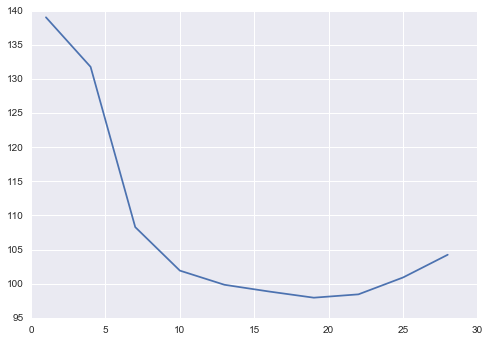

In [41]:
# Do a depth search.

model = Pipeline([ ('features', FunctionTransformer(features)),
                   ('tree', DecisionTreeRegressor()) ])

epsilon = 1e-6
depth_search = np.arange(1, 30, 3)
smapes = []
for depth in depth_search:
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_valid)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    smapes.append(newsmape)
    print('depth = ', depth, 'smape = ', newsmape)
    
plt.plot(depth_search, smapes)
plt.show()